In [1]:
#Imports
import re
import requests
import numpy as np
import pandas as pd
from pandas_gbq import read_gbq
import nltk
from bs4 import BeautifulSoup

In [2]:
# Set up plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (12, 8), 'xtick.labelsize': 14, 'ytick.labelsize': 14})
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind', 8))

In [3]:
#Obtain stopwords list
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nl

[nltk_data]    |   Package semcor is already up-to-date!
[nltk_data]    | Downloading package senseval to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package senseval is already up-to-date!
[nltk_data]    | Downloading package sentiwordnet to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package sentiwordnet is already up-to-date!
[nltk_data]    | Downloading package sentence_polarity to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package sentence_polarity is already up-to-date!
[nltk_data]    | Downloading package shakespeare to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package shakespeare is already up-to-date!
[nltk_data]    | Downloading package sinica_treebank to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package sinica_treebank is already up-to-date!
[nltk_data]    | Downloading package smultron to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]   

True

In [6]:
#Set up query
projectid = 'jrb-gcp-personal'
# If running locally, use a full path to this file.
private_key = '/home/jbandlow/Downloads/jrb-gcp-personal-9e21aa7b9578.json'
configuration = {
   'query': {
     'useLegacySql': False
   }
}
query = r'''
select 
    timestamp,
    text,
    parent,
    ranking,
    id,
    `by` # "by" is a keyword, so must be enclosed by backticks
from `bigquery-public-data.hacker_news.full` 
where 
  type = 'comment' and 
  (
     regexp_contains(lower(text), r'[ \$]btc') or
     regexp_contains(lower(text), r'bitcoin') or
     regexp_contains(lower(text), r'bit coin')
  )
'''

In [7]:
#Obtain Bitcoin related comments
df = read_gbq(query, projectid, private_key=private_key, configuration=configuration)

In [12]:
#Set up query without Bitcoin filter
projectid = 'jrb-gcp-personal'
# If running locally, use a full path to this file.
private_key = '/home/jbandlow/Downloads/jrb-gcp-personal-9e21aa7b9578.json'
configuration = {
   'query': {
     'useLegacySql': False
   }
}
query = r'''
select 
    DATE(timestamp) as day,
    COUNT(1) as number
from `bigquery-public-data.hacker_news.full` 
where 
  type = 'comment'
GROUP BY day
ORDER BY day
'''

In [13]:
#Obtain all comments
df_all = read_gbq(query, projectid, private_key=private_key, configuration=configuration)

In [14]:
df_all.head()

,day,number
0,2006-10-09,2
1,2006-10-10,9
2,2006-10-11,1
3,2007-02-19,5
4,2007-02-20,44


In [15]:
df.timestamp.max()

Timestamp('2018-08-13 07:22:53')

In [16]:
# Clean the html
df['clean_text'] = df.text.apply(lambda _: BeautifulSoup(_, 'html.parser').get_text())

Lemmatizing code, not used for now:

```
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
pos_dict = {
    'N': wordnet.NOUN,
    'V': wordnet.VERB,
    'J': wordnet.ADJ,
    'R': wordnet.ADV
}
def lemmatize(text_list):
    tagged_list = nltk.pos_tag(text_list)
    out = []
    for word, pos in tagged_list:
        simple_pos = pos_dict.get(pos[0])
        if simple_pos:
            out.append(lemmatizer.lemmatize(word, simple_pos))
    return out
```

In [17]:
# Sentiment scores from VADER in nltk
# See: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
"""
If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
"""
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df['compound_sentiment'] = df.clean_text.apply(lambda _: sid.polarity_scores(_)['compound'])

/home/jbandlow/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


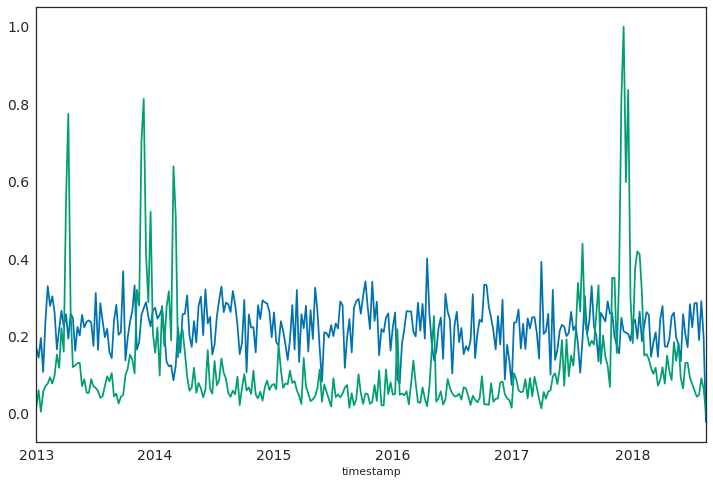

In [18]:
# Plot weekly average sentiment over normalized count
PERIOD = 'W'
START = '2013-01-01'
grp = df.groupby(df.timestamp.dt.to_period(PERIOD))

grp.compound_sentiment.mean()[START:].plot()
(grp.timestamp.count()[START:] / grp.timestamp.count()[START:].max()).plot()

In [20]:
#Get count of all comments
PERIOD = 'W'
START = '2013-01-01'
df_all['day'] = pd.DatetimeIndex(df_all['day'])
grp_all = df_all.groupby(df_all.day.dt.to_period(PERIOD))
all_num_comments = grp_all.number.sum()[START:]

In [21]:
params = {
    'start': START,
    'end': '2018-07-23'
}
url = 'https://api.coindesk.com/v1/bpi/historical/close.json'
r = requests.get(url, params)

In [23]:
pd.DataFrame(r.json()['bpi'], index = ["price"]).T.head()

,price
2013-01-01,13.3041
2013-01-02,13.2800
2013-01-03,13.3979
2013-01-04,13.5000
2013-01-05,13.4400


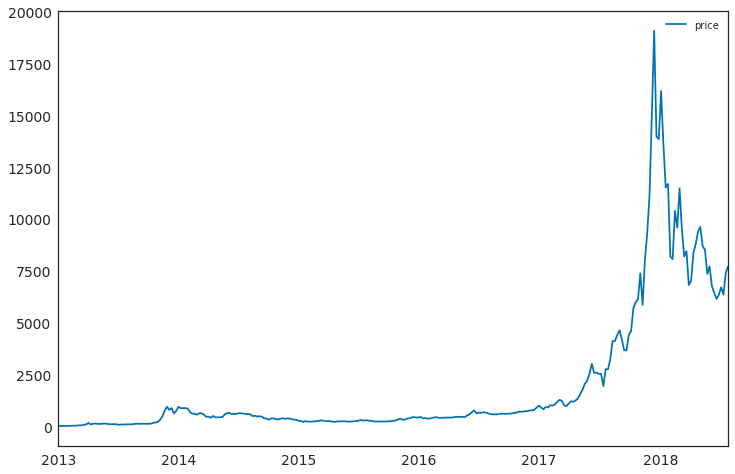

In [24]:
price = pd.DataFrame(r.json()['bpi'], index=['price']).T
price.index = pd.DatetimeIndex(price.index)
wprice = price.groupby(lambda _: _.to_period('W')).last()
wprice.plot()

In [26]:
(wprice / (wprice.shift(1))).head()

,price
2012-12-31/2013-01-06,NaN
2013-01-07/2013-01-13,1.049205
2013-01-14/2013-01-20,1.112213
2013-01-21/2013-01-27,1.134917
2013-01-28/2013-02-03,1.155560


In [27]:
price_delta = wprice.div(wprice.shift(1)) - 1
normalized_sentiment = grp.compound_sentiment.mean() - grp.compound_sentiment.mean().mean()
data = pd.DataFrame(
    {'delta': price_delta.price["2017"], 'sentiment': normalized_sentiment["2017"], 'zero_line': [0 for line in wprice.price]},
    index=price_delta.index
)

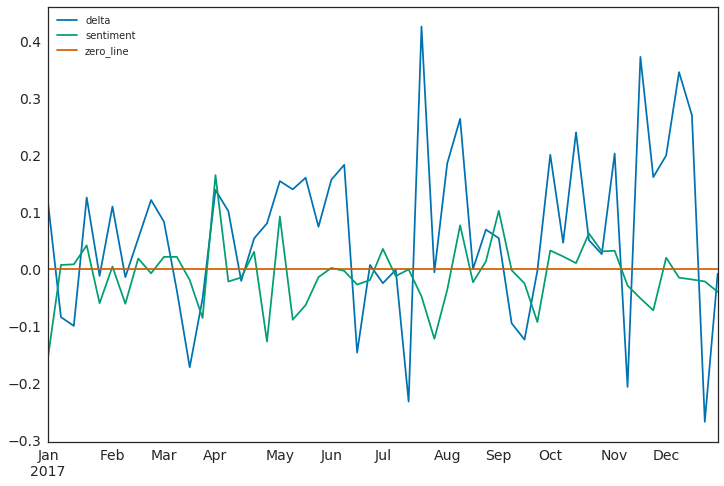

In [28]:
data["2017"].plot()

https://pandas.pydata.org/pandas-docs/stable/tutorials.html is a set of pandas tutorials

In [29]:
data.corr()

,delta,sentiment,zero_line
delta,1.000000,0.081845,NaN
sentiment,0.081845,1.000000,NaN
zero_line,NaN,NaN,NaN


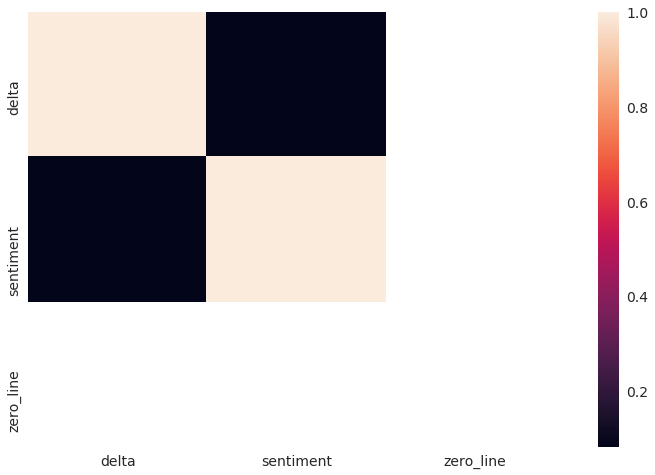

In [30]:
sns.heatmap(data.corr())

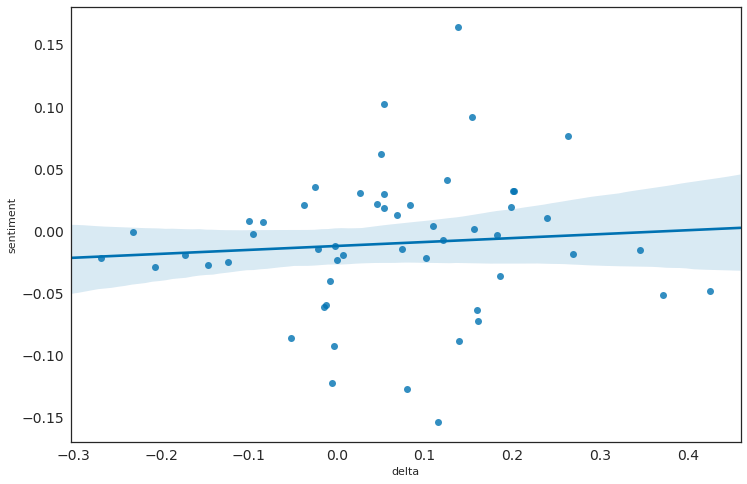

In [31]:
sns.regplot(x='delta', y='sentiment', data=data)

In [32]:
#Printed normalized sentiment
normalized_sentiment.head()

timestamp
2008-09-08/2008-09-14   -0.922191
2009-01-19/2009-01-25    0.550509
2009-08-24/2009-08-30   -0.316091
2010-05-24/2010-05-30   -0.821391
2010-07-19/2010-07-25    0.379609
Freq: W-SUN, Name: compound_sentiment, dtype: float64

In [33]:
#Redefined normalized sentiment to only include dates after 2013
normalized_sentiment = grp.compound_sentiment.mean()[START:] - grp.compound_sentiment.mean()[START:].mean()

In [34]:
#Display normalized sentiment revised
normalized_sentiment.head()

timestamp
2012-12-31/2013-01-06   -0.053059
2013-01-07/2013-01-13   -0.078450
2013-01-14/2013-01-20   -0.027984
2013-01-21/2013-01-27   -0.115521
2013-01-28/2013-02-03    0.016764
Freq: W-SUN, Name: compound_sentiment, dtype: float64

In [35]:
normalized_sentiment_mean = normalized_sentiment

In [36]:
#Define normalized sentiment median
normalized_sentiment_median = grp.compound_sentiment.median() - grp.compound_sentiment.median().mean()

In [37]:
#Display normalized median sentiment
normalized_sentiment_median.head()

timestamp
2008-09-08/2008-09-14   -0.991241
2009-01-19/2009-01-25    0.481459
2009-08-24/2009-08-30   -0.385141
2010-05-24/2010-05-30   -0.890441
2010-07-19/2010-07-25    0.420359
Freq: W-SUN, Name: compound_sentiment, dtype: float64

In [38]:
#Redefined normalized median sentiment the same way as mean sentiment
normalized_sentiment_median = grp.compound_sentiment.median()[START:] - grp.compound_sentiment.median()[START:].mean()

In [39]:
#Display normalized median sentiment
normalized_sentiment_median.head()

timestamp
2012-12-31/2013-01-06   -0.097743
2013-01-07/2013-01-13   -0.123143
2013-01-14/2013-01-20   -0.049193
2013-01-21/2013-01-27   -0.239743
2013-01-28/2013-02-03    0.029057
Freq: W-SUN, Name: compound_sentiment, dtype: float64

In [40]:
#Defined sentiment percent positive
df["sentiment_positivity"] = (df.compound_sentiment > df.compound_sentiment.mean())
grp_positivity = df.groupby(df.timestamp.dt.to_period(PERIOD))
sentiment_percent_positive = grp_positivity.sentiment_positivity.mean()[START:]

In [41]:
#Display sentiment percent positive
sentiment_percent_positive.head()

timestamp
2012-12-31/2013-01-06    0.463415
2013-01-07/2013-01-13    0.456376
2013-01-14/2013-01-20    0.583333
2013-01-21/2013-01-27    0.424460
2013-01-28/2013-02-03    0.545977
Freq: W-SUN, Name: sentiment_positivity, dtype: float64

In [42]:
#Calculate change in mean sentiment each week
normalized_sentiment_mean_delta = normalized_sentiment_mean.div(normalized_sentiment_mean.shift(1)) - 1

In [43]:
#Display change in mean sentiment each week
normalized_sentiment_mean_delta.head()

timestamp
2012-12-31/2013-01-06         NaN
2013-01-07/2013-01-13    0.478535
2013-01-14/2013-01-20   -0.643286
2013-01-21/2013-01-27    3.128096
2013-01-28/2013-02-03   -1.145121
Freq: W-SUN, Name: compound_sentiment, dtype: float64

In [44]:
#Modified sentiment change to be raw form
normalized_sentiment_mean_delta = normalized_sentiment_mean - normalized_sentiment_mean.shift(1)

In [45]:
#Display change in mean sentiment each week
normalized_sentiment_mean_delta.head()

timestamp
2012-12-31/2013-01-06         NaN
2013-01-07/2013-01-13   -0.025391
2013-01-14/2013-01-20    0.050466
2013-01-21/2013-01-27   -0.087537
2013-01-28/2013-02-03    0.132285
Freq: W-SUN, Name: compound_sentiment, dtype: float64

In [46]:
#Calculated change in median sentiment
normalized_sentiment_median_delta = normalized_sentiment_median - normalized_sentiment_median.shift(1)

In [47]:
#Display change in median sentiment each week
normalized_sentiment_median_delta.head()

timestamp
2012-12-31/2013-01-06        NaN
2013-01-07/2013-01-13   -0.02540
2013-01-14/2013-01-20    0.07395
2013-01-21/2013-01-27   -0.19055
2013-01-28/2013-02-03    0.26880
Freq: W-SUN, Name: compound_sentiment, dtype: float64

In [48]:
#Calculated change in sentiment percent positive
sentiment_percent_positive_delta = sentiment_percent_positive - sentiment_percent_positive.shift(1)

In [49]:
#Display change in sentiment percent positive each week
sentiment_percent_positive_delta.head()

timestamp
2012-12-31/2013-01-06         NaN
2013-01-07/2013-01-13   -0.007039
2013-01-14/2013-01-20    0.126957
2013-01-21/2013-01-27   -0.158873
2013-01-28/2013-02-03    0.121517
Freq: W-SUN, Name: sentiment_positivity, dtype: float64

In [50]:
#Calculate number of comments
num_comments = grp.timestamp.count()[START:]

In [51]:
#Normalized number of comments
normalized_num_comments = num_comments / all_num_comments

In [52]:
#Dispaly number of comments
num_comments.head()

timestamp
2012-12-31/2013-01-06     41
2013-01-07/2013-01-13    149
2013-01-14/2013-01-20     12
2013-01-21/2013-01-27    139
2013-01-28/2013-02-03    174
Freq: W-SUN, Name: timestamp, dtype: int64

In [53]:
#Calculate change in number of comments
num_comments_delta = num_comments - num_comments.shift(1)

In [54]:
#Display number of comments change
num_comments_delta.head()

timestamp
2012-12-31/2013-01-06      NaN
2013-01-07/2013-01-13    108.0
2013-01-14/2013-01-20   -137.0
2013-01-21/2013-01-27    127.0
2013-01-28/2013-02-03     35.0
Freq: W-SUN, Name: timestamp, dtype: float64

In [55]:
#Convert changes to binary form
bin_normalized_sentiment_mean = (normalized_sentiment_mean > 0).astype(int)
bin_normalized_sentiment_median = (normalized_sentiment_median > 0).astype(int)
bin_normalized_sentiment_mean_delta = (normalized_sentiment_mean_delta > 0).astype(int)
bin_normalized_sentiment_median_delta = (normalized_sentiment_median_delta > 0).astype(int)
bin_sentiment_percent_positive_delta = (sentiment_percent_positive_delta > 0).astype(int)
bin_num_comments_delta = (num_comments_delta > 0).astype(int)
bin_price_delta = (price_delta.price > 0).astype(int)

In [56]:
#View binary changes
bin_normalized_sentiment_mean_delta
bin_normalized_sentiment_median_delta
bin_num_comments_delta
bin_price_delta

2012-12-31/2013-01-06    0
2013-01-07/2013-01-13    1
2013-01-14/2013-01-20    1
2013-01-21/2013-01-27    1
2013-01-28/2013-02-03    1
2013-02-04/2013-02-10    1
2013-02-11/2013-02-17    1
2013-02-18/2013-02-24    1
2013-02-25/2013-03-03    1
2013-03-04/2013-03-10    1
2013-03-11/2013-03-17    1
2013-03-18/2013-03-24    1
2013-03-25/2013-03-31    1
2013-04-01/2013-04-07    1
2013-04-08/2013-04-14    0
2013-04-15/2013-04-21    1
2013-04-22/2013-04-28    1
2013-04-29/2013-05-05    0
2013-05-06/2013-05-12    0
2013-05-13/2013-05-19    1
2013-05-20/2013-05-26    1
2013-05-27/2013-06-02    0
2013-06-03/2013-06-09    0
2013-06-10/2013-06-16    0
2013-06-17/2013-06-23    1
2013-06-24/2013-06-30    0
2013-07-01/2013-07-07    0
2013-07-08/2013-07-14    1
2013-07-15/2013-07-21    0
2013-07-22/2013-07-28    1
                        ..
2018-01-01/2018-01-07    1
2018-01-08/2018-01-14    0
2018-01-15/2018-01-21    0
2018-01-22/2018-01-28    1
2018-01-29/2018-02-04    0
2018-02-05/2018-02-11    0
2

In [57]:
#Adjust all non-price columns by 1
adjusted_normalized_sentiment_mean = normalized_sentiment_mean.shift(1)
adjusted_normalized_sentiment_median = normalized_sentiment_median.shift(1)
adjusted_sentiment_percent_positive = sentiment_percent_positive.shift(1)
adjusted_normalized_sentiment_mean_delta = normalized_sentiment_mean_delta.shift(1)
adjusted_normalized_sentiment_median_delta = normalized_sentiment_median_delta.shift(1)
adjusted_sentiment_percent_positive_delta = sentiment_percent_positive_delta.shift(1)
adjusted_bin_normalized_sentiment_mean = bin_normalized_sentiment_mean.shift(1)
adjusted_bin_normalized_sentiment_median = bin_normalized_sentiment_median.shift(1)
adjusted_bin_normalized_sentiment_mean_delta = bin_normalized_sentiment_mean_delta.shift(1)
adjusted_bin_normalized_sentiment_median_delta = bin_normalized_sentiment_median_delta.shift(1)
adjusted_bin_sentiment_percent_positive_delta = bin_sentiment_percent_positive_delta.shift(1)
adjusted_num_comments = num_comments.shift(1)
adjusted_num_comments_delta = num_comments_delta.shift(1)
adjusted_bin_num_comments_delta = bin_num_comments_delta.shift(1)

In [58]:
#Created DataFrame
all_data = pd.DataFrame(
    {'price': wprice.price, 'delta price': price_delta.price, 'binary delta price': bin_price_delta, 'sentiment mean': adjusted_normalized_sentiment_mean, 'sentiment median': adjusted_normalized_sentiment_median, 'sentiment percent positive': adjusted_sentiment_percent_positive, 'sentiment mean delta': adjusted_normalized_sentiment_mean_delta, 'sentiment median delta': adjusted_normalized_sentiment_median_delta, 'sentiment percent positive delta': adjusted_sentiment_percent_positive_delta, 'binary sentiment mean': adjusted_bin_normalized_sentiment_mean, 'binary sentiment median': adjusted_bin_normalized_sentiment_median, 'binary sentiment mean delta': adjusted_bin_normalized_sentiment_mean_delta, 'binary sentiment median delta': adjusted_bin_normalized_sentiment_median_delta, 'binary sentiment percent positive delta': adjusted_bin_sentiment_percent_positive_delta, 'number of comments': adjusted_num_comments, 'number of comments delta': adjusted_num_comments_delta, 'binary number of comments delta': adjusted_bin_num_comments_delta},
    index=price_delta.index
)

In [59]:
#Display data frame
all_data.head()

,binary delta price,binary number of comments delta,binary sentiment mean,binary sentiment mean delta,binary sentiment median,binary sentiment median delta,binary sentiment percent positive delta,delta price,number of comments,number of comments delta,price,sentiment mean,sentiment mean delta,sentiment median,sentiment median delta,sentiment percent positive,sentiment percent positive delta
2012-12-31/2013-01-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4540,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07/2013-01-13,1,0.0,0.0,0.0,0.0,0.0,0.0,0.049205,41.0,NaN,14.1160,-0.053059,NaN,-0.097743,NaN,0.463415,NaN
2013-01-14/2013-01-20,1,1.0,0.0,0.0,0.0,0.0,0.0,0.112213,149.0,108.0,15.7000,-0.078450,-0.025391,-0.123143,-0.02540,0.456376,-0.007039
2013-01-21/2013-01-27,1,0.0,0.0,1.0,0.0,1.0,1.0,0.134917,12.0,-137.0,17.8182,-0.027984,0.050466,-0.049193,0.07395,0.583333,0.126957
2013-01-28/2013-02-03,1,1.0,0.0,0.0,0.0,0.0,0.0,0.155560,139.0,127.0,20.5900,-0.115521,-0.087537,-0.239743,-0.19055,0.424460,-0.158873


In [60]:
#Look for correlations
all_data_corr = all_data.corr()

In [61]:
#Display correlations
all_data_corr

,binary delta price,binary number of comments delta,binary sentiment mean,binary sentiment mean delta,binary sentiment median,binary sentiment median delta,binary sentiment percent positive delta,delta price,number of comments,number of comments delta,price,sentiment mean,sentiment mean delta,sentiment median,sentiment median delta,sentiment percent positive,sentiment percent positive delta
binary delta price,1.000000,0.061768,0.000048,0.043117,-0.086917,0.020979,0.016355,0.674816,-0.006163,0.055915,0.015616,0.017320,0.049117,-0.023833,0.015953,-0.021123,-0.014950
binary number of comments delta,0.061768,1.000000,0.015242,-0.034742,0.046608,0.055205,0.028565,0.055933,0.235435,0.576589,-0.052147,0.010027,-0.013525,0.089916,0.057636,0.046775,0.032703
binary sentiment mean,0.000048,0.015242,1.000000,0.511080,0.712047,0.421050,0.461498,-0.011477,-0.059343,-0.006192,-0.061052,0.804488,0.535437,0.674688,0.400954,0.694146,0.436509
binary sentiment mean delta,0.043117,-0.034742,0.511080,1.000000,0.502316,0.689672,0.759118,0.067369,-0.048291,-0.072146,-0.037578,0.541769,0.786046,0.496680,0.663849,0.515243,0.708300
binary sentiment median,-0.086917,0.046608,0.712047,0.502316,1.000000,0.522233,0.490726,-0.036193,-0.081885,-0.025852,-0.084137,0.728497,0.520062,0.776913,0.531249,0.730096,0.499192
binary sentiment median delta,0.020979,0.055205,0.421050,0.689672,0.522233,1.000000,0.765809,0.067033,-0.008042,-0.014299,-0.044799,0.444133,0.691781,0.525976,0.751411,0.507644,0.713893
binary sentiment percent positive delta,0.016355,0.028565,0.461498,0.759118,0.490726,0.765809,1.000000,0.047068,0.062956,0.002673,0.010205,0.490795,0.731877,0.498509,0.701992,0.545092,0.764738
delta price,0.674816,0.055933,-0.011477,0.067369,-0.036193,0.067033,0.047068,1.000000,0.125251,0.096186,0.031521,0.003653,0.061209,-0.021967,0.044204,-0.017240,0.015430
number of comments,-0.006163,0.235435,-0.059343,-0.048291,-0.081885,-0.008042,0.062956,0.125251,1.000000,0.364745,0.470976,-0.098788,-0.038438,-0.055567,-0.017489,-0.070923,-0.008389
number of comments delta,0.055915,0.576589,-0.006192,-0.072146,-0.025852,-0.014299,0.002673,0.096186,0.364745,1.000000,-0.012491,-0.048618,-0.084483,-0.023685,-0.036871,-0.041867,-0.036361


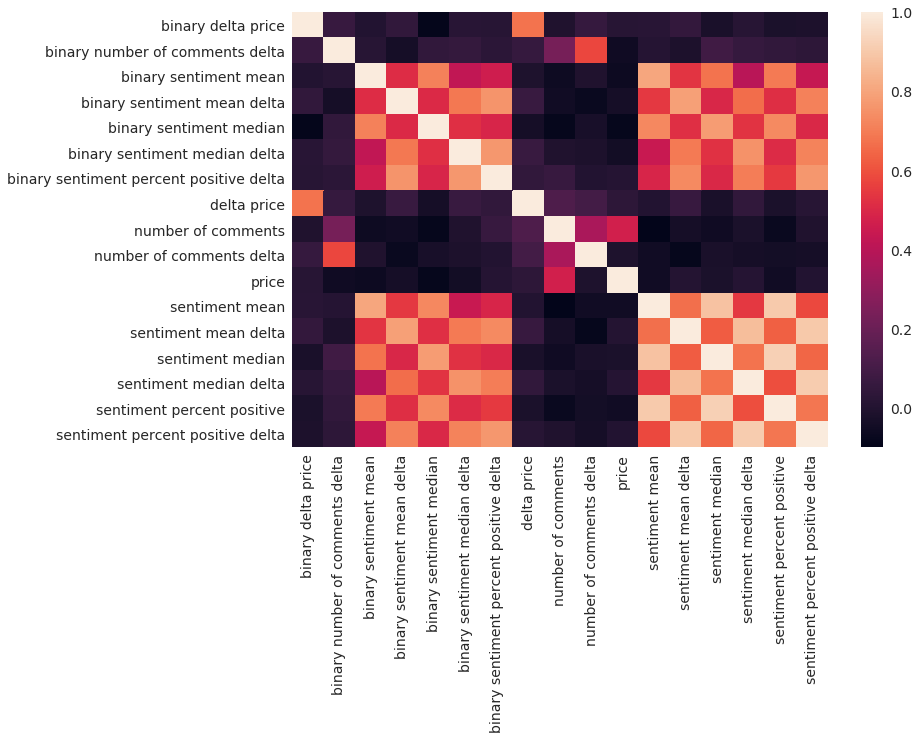

In [62]:
sns.heatmap(all_data_corr)

In [63]:
#Try multiple regression with stats model
import statsmodels.api as sm

/home/jbandlow/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [64]:
all_data.dropna(inplace=True)
x = all_data[["sentiment mean", "number of comments"]]
y = all_data["delta price"]
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary())
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            delta price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.338
Date:                Tue, 14 Aug 2018   Prob (F-statistic):             0.0983
Time:                        16:49:56   Log-Likelihood:                 160.35
No. Observations:                 289   AIC:                            -314.7
Df Residuals:                     286   BIC:                            -303.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0156      0

In [66]:
all_data.head()

,binary delta price,binary number of comments delta,binary sentiment mean,binary sentiment mean delta,binary sentiment median,binary sentiment median delta,binary sentiment percent positive delta,delta price,number of comments,number of comments delta,price,sentiment mean,sentiment mean delta,sentiment median,sentiment median delta,sentiment percent positive,sentiment percent positive delta
2013-01-14/2013-01-20,1,1.0,0.0,0.0,0.0,0.0,0.0,0.112213,149.0,108.0,15.7000,-0.078450,-0.025391,-0.123143,-0.02540,0.456376,-0.007039
2013-01-21/2013-01-27,1,0.0,0.0,1.0,0.0,1.0,1.0,0.134917,12.0,-137.0,17.8182,-0.027984,0.050466,-0.049193,0.07395,0.583333,0.126957
2013-01-28/2013-02-03,1,1.0,0.0,0.0,0.0,0.0,0.0,0.155560,139.0,127.0,20.5900,-0.115521,-0.087537,-0.239743,-0.19055,0.424460,-0.158873
2013-02-04/2013-02-10,1,1.0,1.0,1.0,1.0,1.0,1.0,0.164148,174.0,35.0,23.9698,0.016764,0.132285,0.029057,0.26880,0.545977,0.121517
2013-02-11/2013-02-17,1,1.0,1.0,1.0,1.0,1.0,1.0,0.118683,191.0,17.0,26.8146,0.106190,0.089425,0.140357,0.11130,0.623037,0.077060


In [83]:
all_data = pd.DataFrame({"delta price": price_delta.price}, index = price_delta.index)
for i in range(1,10):
  all_data["sentiment mean " + str(i)] = sentiment_percent_positive.shift(i)
  all_data["number of comments " + str(i)] = normalized_num_comments.shift(i)
  all_data["delta price " + str(i)] = price_delta.shift(i)
for i in range(10,20):
  all_data["sentiment mean " + str(i)] = sentiment_percent_positive.shift(i)
  all_data["delta price " + str(i)] = price_delta.shift(i)
for i in range(20,50):
  all_data["delta price " + str(i)] = price_delta.shift(i)
all_data.dropna(inplace = False)
all_data
rsquared_values = {}
for i in range(1,10):
  x = all_data[all_data.columns[1:3*i+1]][i+1:len(all_data.columns[-1]) - 96]
  y = all_data["delta price"][i+1:len(all_data.columns[-1]) - 96]
  x = sm.add_constant(x)
  model = sm.OLS(y,x).fit()
  rsquared_values[i] = model.rsquared
for i in range(10,20):
  x = all_data[all_data.columns[1:2*i+10]][i+1:len(all_data.columns[-1]) - 96]
  y = all_data["delta price"][i+1:len(all_data.columns[-1]) - 96]
  x = sm.add_constant(x)
  model = sm.OLS(y,x).fit()
  rsquared_values[i] = model.rsquared
for i in range(20,50):
  x = all_data[all_data.columns[1:i+29]][i+1:len(all_data.columns[-1]) - 96]
  y = all_data["delta price"][i+1:len(all_data.columns[-1]) - 96]
  x = sm.add_constant(x)
  model = sm.OLS(y,x, hasconst=True).fit()
  rsquared_values[i] = model.rsquared
pd.DataFrame(rsquared_values, index = ["week"]).T

,week
1,0.031042
2,0.099623
3,0.122802
4,0.136768
5,0.155208
6,0.161300
7,0.176400
8,0.186307
9,0.191840
10,0.210808


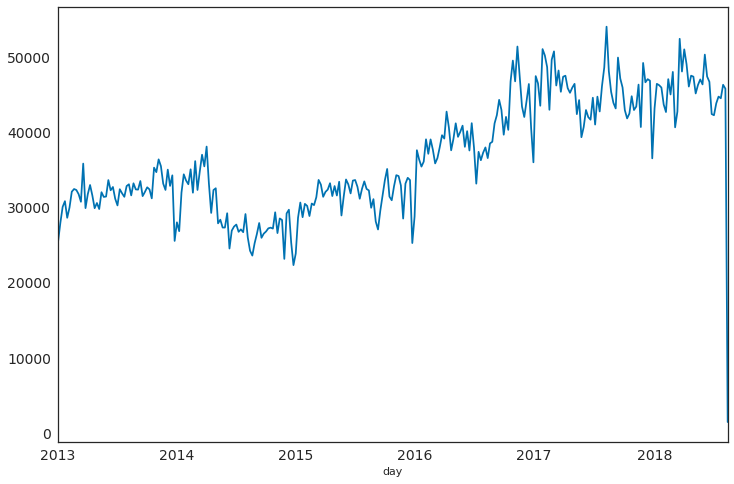

In [84]:
all_num_comments.plot()

In [85]:
x

,const,sentiment mean 1,number of comments 1,delta price 1,sentiment mean 2,number of comments 2,delta price 2,sentiment mean 3,number of comments 3,delta price 3,...,delta price 40,delta price 41,delta price 42,delta price 43,delta price 44,delta price 45,delta price 46,delta price 47,delta price 48,delta price 49
2013-12-16/2013-12-22,1.0,0.551481,0.021584,0.105699,0.583906,0.029105,-0.160020,0.575637,0.061986,0.260251,...,0.030435,0.333333,0.154232,0.114691,0.118683,0.164148,0.155560,0.134917,0.112213,0.049205
2013-12-23/2013-12-29,1.0,0.553307,0.037514,-0.297513,0.551481,0.021584,0.105699,0.583906,0.029105,-0.160020,...,0.508439,0.030435,0.333333,0.154232,0.114691,0.118683,0.164148,0.155560,0.134917,0.112213
2013-12-30/2014-01-05,1.0,0.575875,0.020123,0.205976,0.553307,0.037514,-0.297513,0.551481,0.021584,0.105699,...,0.301119,0.508439,0.030435,0.333333,0.154232,0.114691,0.118683,0.164148,0.155560,0.134917
2014-01-06/2014-01-12,1.0,0.586563,0.013815,0.261755,0.575875,0.020123,0.205976,0.553307,0.037514,-0.297513,...,0.744609,0.301119,0.508439,0.030435,0.333333,0.154232,0.114691,0.118683,0.164148,0.155560
2014-01-13/2014-01-19,1.0,0.558394,0.020420,-0.071092,0.586563,0.013815,0.261755,0.575875,0.020123,0.205976,...,-0.445475,0.744609,0.301119,0.508439,0.030435,0.333333,0.154232,0.114691,0.118683,0.164148
2014-01-20/2014-01-26,1.0,0.578512,0.007573,0.006203,0.558394,0.020420,-0.071092,0.586563,0.013815,0.261755,...,0.324444,-0.445475,0.744609,0.301119,0.508439,0.030435,0.333333,0.154232,0.114691,0.118683
2014-01-27/2014-02-02,1.0,0.581633,0.019949,0.001675,0.578512,0.007573,0.006203,0.558394,0.020420,-0.071092,...,0.127889,0.324444,-0.445475,0.744609,0.301119,0.508439,0.030435,0.333333,0.154232,0.114691
2014-02-03/2014-02-09,1.0,0.541860,0.012808,-0.029287,0.581633,0.019949,0.001675,0.578512,0.007573,0.006203,...,-0.137339,0.127889,0.324444,-0.445475,0.744609,0.301119,0.508439,0.030435,0.333333,0.154232
2014-02-10/2014-02-16,1.0,0.475700,0.020533,-0.201829,0.541860,0.012808,-0.029287,0.581633,0.019949,0.001675,...,-0.010002,-0.137339,0.127889,0.324444,-0.445475,0.744609,0.301119,0.508439,0.030435,0.333333
2014-02-17/2014-02-23,1.0,0.471117,0.022223,-0.104533,0.475700,0.020533,-0.201829,0.541860,0.012808,-0.029287,...,0.066887,-0.010002,-0.137339,0.127889,0.324444,-0.445475,0.744609,0.301119,0.508439,0.030435


In [86]:
weights = pd.DataFrame(model.params)
sentiment_weights = weights[weights.index.str.contains("sentiment")]
comments_weights = weights[weights.index.str.contains("comments")]
price_change_weights = weights[weights.index.str.contains("price")]

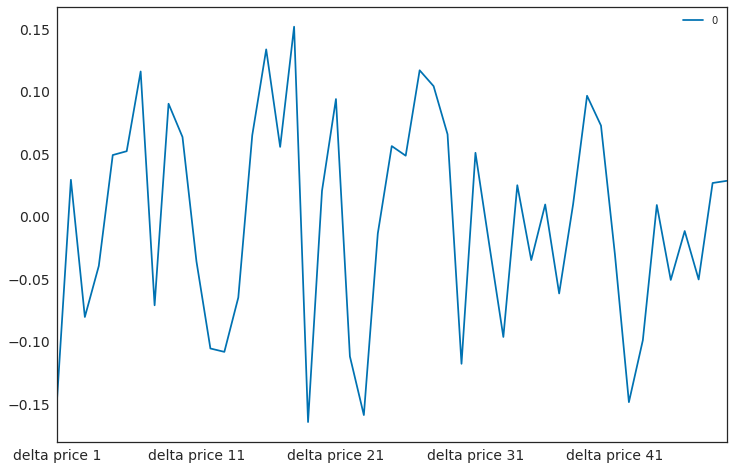

In [87]:
price_change_weights.plot()

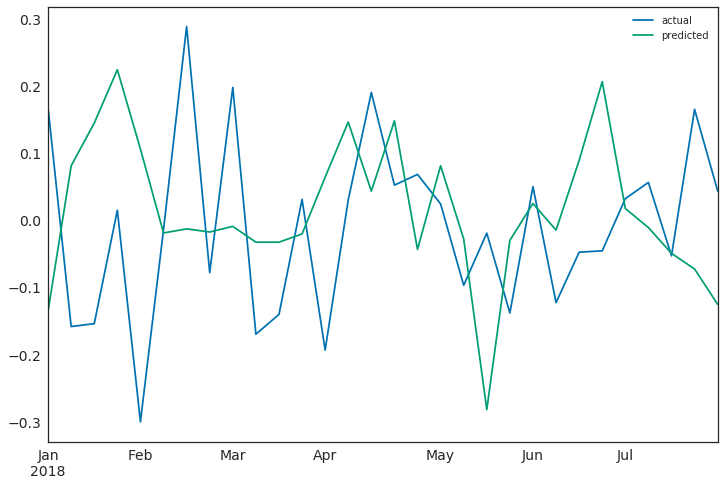

In [111]:
results = pd.DataFrame({
    "actual":all_data["delta price"],
    "predicted": model.predict(sm.add_constant(all_data[all_data.columns[1:i+29]]))})
results['2018'].plot()

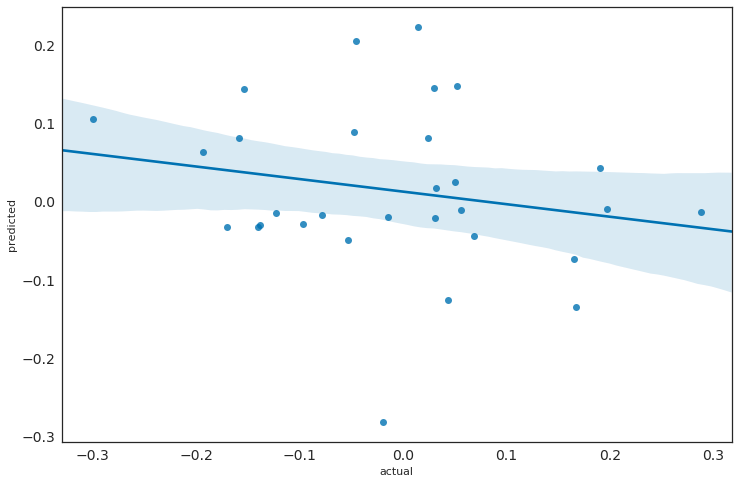

In [110]:
sns.regplot(x='actual', y='predicted', data=results['2018'])